In [1]:
#Import dependencies
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
from statistics import mean
from sklearn.linear_model import LinearRegression
from statsmodels.regression.linear_model import OLS
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm

%matplotlib notebook

In [2]:
#Read the output csv files of DataCleaning.ipynb which are saved in Google drive 
cpi_df = pd.read_csv("outcome/cpi_data.csv")
wpi_df = pd.read_csv("outcome/wpi_data.csv")


In [3]:
cpi_df.tail()

,Qtr,Sydney,Melbourne,Brisbane,Adelaide,Perth,Hobart,Darwin,Canberra,Australia
52,2022-03-01,1.7,2.3,2.2,1.9,3.3,2.0,2.1,2.2,2.1
53,2022-06-01,1.6,1.8,2.1,2.1,1.7,1.8,2.1,1.6,1.8
54,2022-09-01,2.3,2.1,1.8,2.6,-0.5,2.3,1.9,1.9,1.8
55,2022-12-01,1.8,1.6,1.5,1.7,3.6,1.5,0.9,1.2,1.9
56,2023-03-01,1.4,1.2,1.9,1.2,0.9,1.2,1.3,1.4,1.4


In [4]:
#Drop the last row in the CPI data table just to make the number of CPI data and WPI data records equal.
cpi_df = cpi_df.drop(labels = 56 , axis = 0)

#Drop the columns that contain CPI for differnt cities
cpi_df = cpi_df.drop(cpi_df.iloc[:,1:9], axis = 1)

#Rename the 'Australia' column
cpi_df = cpi_df.rename(columns = {'Australia' : 'CPI_percentage_change'})

cpi_df.tail()

,Qtr,CPI_percentage_change
51,2021-12-01,1.3
52,2022-03-01,2.1
53,2022-06-01,1.8
54,2022-09-01,1.8
55,2022-12-01,1.9


In [5]:
wpi_df.tail()

,Qtr,WPI_percentage_change
51,2021-12-01,0.7
52,2022-03-01,0.7
53,2022-06-01,0.8
54,2022-09-01,1.1
55,2022-12-01,0.8


In [6]:
combined_df = pd.merge(wpi_df,cpi_df,on = "Qtr")
combined_df.head(5)

,Qtr,WPI_percentage_change,CPI_percentage_change
0,2009-03-01,0.9,0.1
1,2009-06-01,0.8,0.4
2,2009-09-01,0.4,1.0
3,2009-12-01,0.8,0.5
4,2010-03-01,1.0,1.0


In [7]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56 entries, 0 to 55
Data columns (total 3 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Qtr                    56 non-null     object 
 1   WPI_percentage_change  56 non-null     float64
 2   CPI_percentage_change  56 non-null     float64
dtypes: float64(2), object(1)
memory usage: 1.8+ KB


In [8]:
combined_df.set_index("Qtr", inplace = True)


In [9]:
wpi = wpi_df.set_index('Qtr')
wpi.head()

,WPI_percentage_change
Qtr,
2009-03-01,0.9
2009-06-01,0.8
2009-09-01,0.4
2009-12-01,0.8
2010-03-01,1.0


## **Apply Augmented Dickey Fuller Test to find out if WPI Time Series has a stochastic trend**

# The hypotheses for the ADF test:

*   The null hypotheses : Time series is not stationary.
*   The alternative hypotheses : Time series is stationary.


In [10]:
adftest_original = adfuller(wpi_df['WPI_percentage_change'].tolist(), autolag = 'AIC')

adf_test1 = adftest_original[0]
p_val_test1 = adftest_original[1]
lags_test1 = adftest_original[2]
obs_test1 = adftest_original[3]
cv_1_test1 = adftest_original[4]["1%"]
cv_5_test1 = adftest_original[4]["5%"]
cv_10_test1 = adftest_original[4]["10%"]

ADF_test1_summary = pd.DataFrame({"ADF": adf_test1,
                                  "P-Value" : p_val_test1,
                                  "Num of Lags": lags_test1,
                                  "Num of Observations used":obs_test1,
                                  "CV at 1% level": cv_1_test1,
                                  "CV at 5% level": cv_5_test1,
                                  "CV at 10% level": cv_10_test1}, index = [0])

ADF_test1_summary

,ADF,P-Value,Num of Lags,Num of Observations used,CV at 1% level,CV at 5% level,CV at 10% level
0,-2.070267,0.256637,6,49,-3.571472,-2.922629,-2.599336


The p-value of the ADF test is 0.256 which is greater than 0.05 and the ADF test statistic is greater than all 3 critical values. Therefore there is no reason to reject null hypotheses. That means we have to accept that the Time series is not stationary.

### Detrend the Time Series using First Differencing method

In [11]:
#Get the difference of current period vs previous period wpi percentage change
wpi['First_diff_WPI_percentage_change']  = wpi['WPI_percentage_change'] - wpi['WPI_percentage_change'].shift(1)

In [12]:
wpi.head()

,WPI_percentage_change,First_diff_WPI_percentage_change
Qtr,,
2009-03-01,0.9,NaN
2009-06-01,0.8,-0.1
2009-09-01,0.4,-0.4
2009-12-01,0.8,0.4
2010-03-01,1.0,0.2


<IPython.core.display.Javascript object>


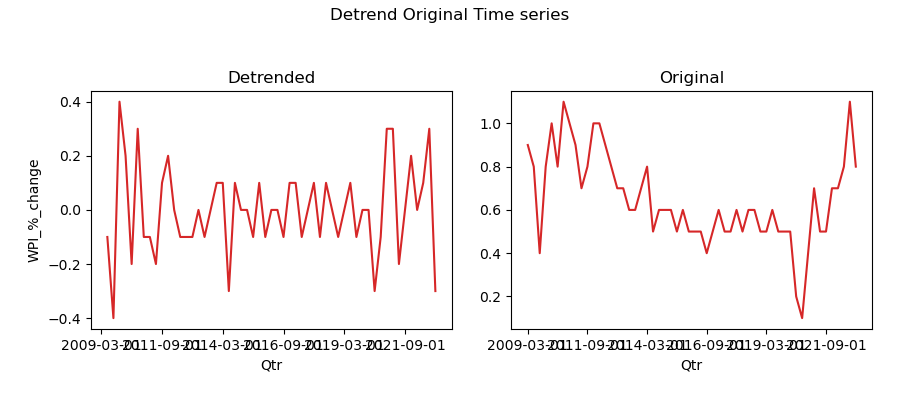

In [13]:
#Create subplots for Original Time series and Regression fit
plt.figure(figsize=(9,4))

ax1 = plt.subplot(1,2,1)
wpi['First_diff_WPI_percentage_change'].plot(color="tab:red", title="Detrended", ax=ax1, ylabel="WPI_%_change")
ax2 = plt.subplot(1,2,2)
wpi['WPI_percentage_change'].plot(color="tab:red", title="Original", ax=ax2)

plt.suptitle("Detrend Original Time series")
plt.tight_layout(pad=2.0)
plt.show()

### Apply ADF test again for the Detrended time series to check for stationary

In [14]:
adftest_detrend = adfuller(wpi['First_diff_WPI_percentage_change'].dropna(), autolag = 'AIC')

adf_test2 = adftest_detrend[0]
p_val_test2 = adftest_detrend[1]
lags_test2 = adftest_detrend[2]
obs_test2 = adftest_detrend[3]
cv_1_test2 = adftest_detrend[4]["1%"]
cv_5_test2 = adftest_detrend[4]["5%"]
cv_10_test2 = adftest_detrend[4]["10%"]

ADF_test2_summary = pd.DataFrame({"ADF": adf_test2,
                                  "P-Value" : p_val_test2,
                                  "Num of Lags": lags_test2,
                                  "Num of Observations used":obs_test2,
                                  "CV at 1% level": cv_1_test2,
                                  "CV at 5% level": cv_5_test2,
                                  "CV at 10% level": cv_10_test2}, index = [0])

ADF_test2_summary

,ADF,P-Value,Num of Lags,Num of Observations used,CV at 1% level,CV at 5% level,CV at 10% level
0,-3.406245,0.010748,5,49,-3.571472,-2.922629,-2.599336


The p-value of the ADF test is 0.0107 which is less than 0.05 and the ADF test statistic is less than critical values at 5%. Therefore there is enough evidence to reject null hypotheses and to accept that the First differenced Time series data is stationary.

<IPython.core.display.Javascript object>


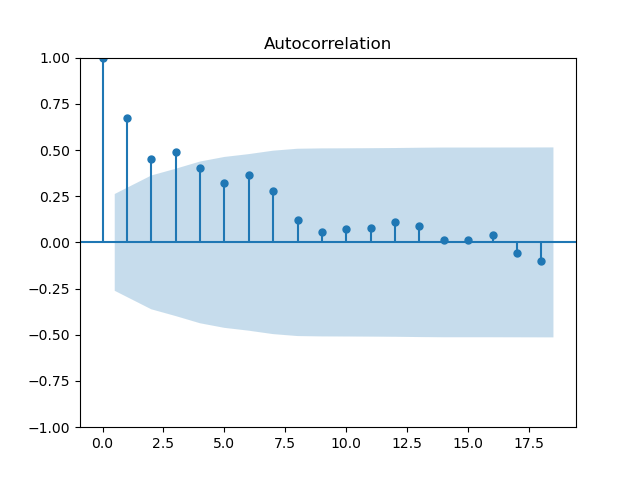

In [15]:
#Create the autocorrelation plot for original WPI percentage change time series
fig = plot_acf(wpi['WPI_percentage_change'])
fig.show()

C:\Users\uocka\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


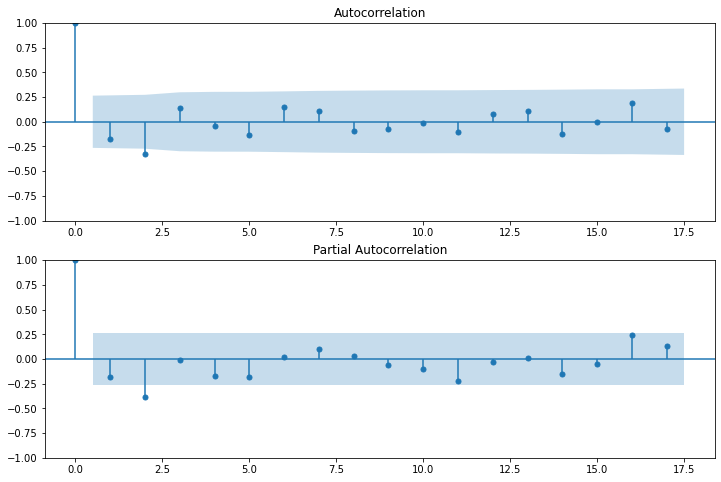

In [16]:
#Create autocorrelation and partial autocorrelation plots for First differenced WPI percentage change time series

%matplotlib inline
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(wpi['First_diff_WPI_percentage_change'].dropna(),lags=17,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(wpi['First_diff_WPI_percentage_change'].dropna(),lags=17,ax=ax2)

### Fit a Linear Regression model

In [19]:
# Create a copy of wpi dataframe
detrend_df = wpi.copy()
# drop the original value column and leave the first differenced values only
detrend_df = detrend_df.drop(detrend_df.iloc[:,0:1],axis =1)
# drop null values
detrend_wpi_df = detrend_df.dropna()
detrend_wpi_df.head()

,First_diff_WPI_percentage_change
Qtr,
2009-06-01,-0.1
2009-09-01,-0.4
2009-12-01,0.4
2010-03-01,0.2
2010-06-01,-0.2


In [20]:
# Add a dummy variable named as Time for Qtr
reg_wpi_df = detrend_wpi_df.copy()
reg_wpi_df['Time'] = np.arange(len(detrend_wpi_df.index))
reg_wpi_df.head()

,First_diff_WPI_percentage_change,Time
Qtr,,
2009-06-01,-0.1,0
2009-09-01,-0.4,1
2009-12-01,0.4,2
2010-03-01,0.2,3
2010-06-01,-0.2,4


In [22]:
# Reformat data of the independent variable X as a single-column array
X = reg_wpi_df.loc[:, ["Time"]]
y = reg_wpi_df.loc[:, 'First_diff_WPI_percentage_change']

# Display sample data
model = LinearRegression()
model.fit(X, y)

LinearRegression()

In [23]:
# Create an array for the dependent variable y
y_pred = pd.Series(model.predict(X), index=X.index)
df_y_pred = reg_wpi_df.copy()
df_y_pred["wpi_percentage_change_predicted"] = y_pred
df_y_pred.tail(5)

,First_diff_WPI_percentage_change,Time,wpi_percentage_change_predicted
Qtr,,,
2021-12-01,0.2,50,0.016934
2022-03-01,0.0,51,0.017749
2022-06-01,0.1,52,0.018564
2022-09-01,0.3,53,0.019380
2022-12-01,-0.3,54,0.020195


In [24]:
 # Display the slope
print(f"Model's slope: {model.coef_}")

Model's slope: [0.0008153]


In [25]:
 # Display the y-intercept
print(f"Model's y-intercept: {model.intercept_}")

Model's y-intercept: -0.023831168831168842


In [26]:
 # Display the model's best fit line formula
print(f"Model's formula: y = {model.intercept_} + {model.coef_[0]}X")

Model's formula: y = -0.023831168831168842 + 0.0008152958152958156X


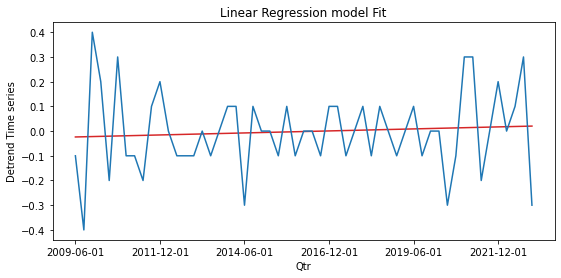

In [28]:
plt.figure(figsize=(9,4))

ax1 = plt.subplot()
y_pred.plot(color="tab:red", title="Linear Regression model Fit", ax=ax1, ylabel="Detrend Time series")
ax2 = plt.subplot()
detrend_wpi_df['First_diff_WPI_percentage_change'].plot(color="tab:blue", ax=ax1)

plt.show()

In [31]:
# Display the formula to predict the wpi_percentage change in 2023 first quarter
print(f"Model's formula: y = {model.intercept_} + {model.coef_[0]} * 55")

# Predict the wpi_percentage change in 2023 first quarter
Time_55 = model.intercept_ + model.coef_[0] * 55

#Add the 2022 Q4 original value to the predicted value in order to get the 2023 Q1 value because our model 
#is fitted to differenced time series 
Q1_23 = 0.8 + Time_55

# Display the prediction
print(f"Predicted difference for the 2023 Qtr 1: {Time_55:.4f}")
print(f"Predicted wpi_%_change for the 2023 Qtr 1:", Q1_23)

Model's formula: y = -0.023831168831168842 + 0.0008152958152958156 * 55
Predicted difference for the 2023 Qtr 1: 0.0210
Predicted wpi_%_change for the 2023 Qtr 1: 0.8210101010101011
